In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# Map classes with automap
measurement = Base.classes.measurement
station = Base.classes.station

# Create a session
session = Session(engine)

In [6]:
# Print out all of the class names (i.e., table names) that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
first_measurement = session.query(Measurement).first()
print(first_measurement.__dict__)

#close the session when done
session.close()


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000020AEB441CD0>, 'id': 1, 'station': 'USC00519397', 'date': '2010-01-01', 'prcp': 0.08, 'tobs': 65.0}


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(most_recent_date)

session.close()

2017-08-23


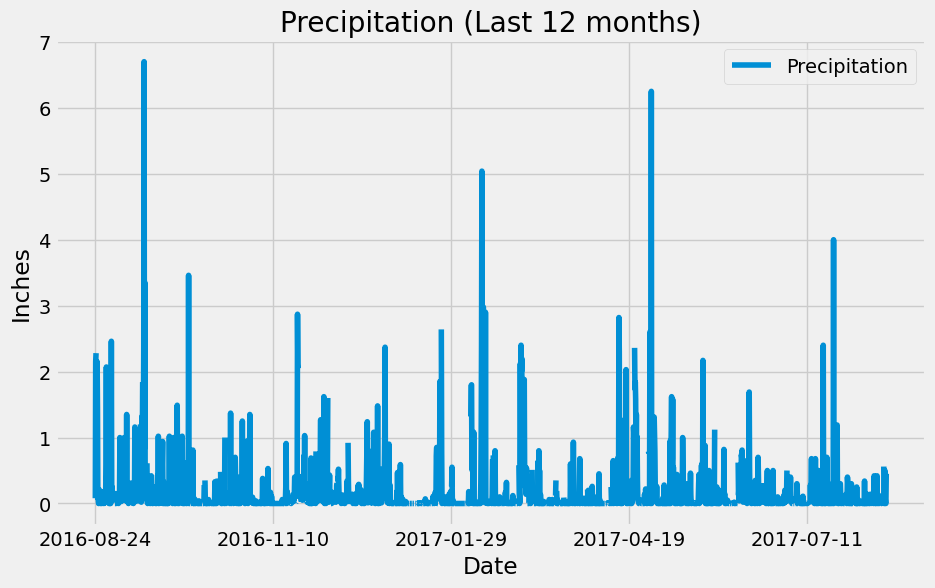

In [10]:
from datetime import datetime, timedelta # without this, timedelta will not be defined and an error will occur

# Find the most recent date in the data set
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the DataFrame by date
df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot('date', 'precipitation', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation (Last 12 months)')
plt.legend(['Precipitation'])

In [11]:
summary_statistics = df['precipitation'].describe()
summary_statistics

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [13]:
# Design a query to find the most active stations
most_active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station)
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# This will return a list of tuples with the station ID and the count of measurements
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Extract the ID of the most active station
most_active_station_id = most_active_stations[0][0]

# Calculate the lowest temperature recorded, highest temperature recorded, and average temperature
temps = session.query(
    func.min(Measurement.tobs), 
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).one()

lowest_temp, highest_temp, average_temp = temps

print(f"Lowest Temperature: {lowest_temp}\n"
      f"Highest Temperature: {highest_temp}\n"
      f"Average Temperature: {average_temp:.2f}")


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


In [15]:
# Find the most active station
most_active_station = session.query(
    Measurement.station,
    func.count(Measurement.station)
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

# Get the ID of the most active station
most_active_station_id = most_active_station[0]

# Print the most active station ID
print("The most active station ID is:", most_active_station_id)


The most active station ID is: USC00519281


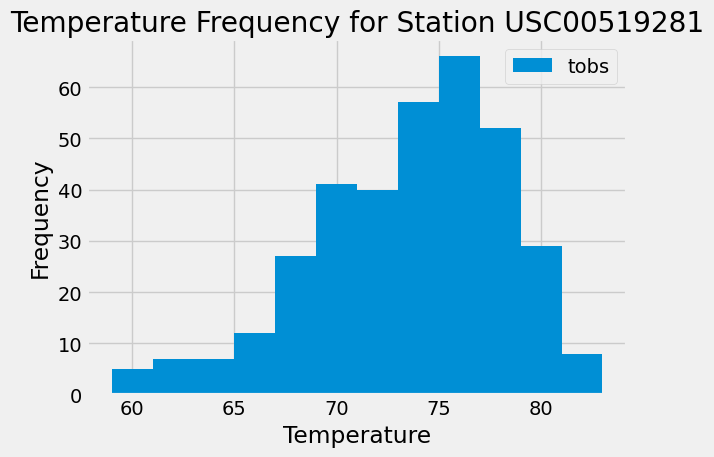

In [16]:
# Set the most active station id
most_active_station_id = 'USC00519281'

# the most recent date in the data set
most_recent_date = '2017-08-23' 

# Convert the most recent date string to a datetime object
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in the data set
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the last 12 months of temperature observation data for this station
results = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the results to a pandas DataFrame
temperature_df = pd.DataFrame(results, columns=['tobs'])

# Plot the results as a histogram with bins=12
temperature_df.plot.hist(bins=12, title=f'Temperature Frequency for Station {most_active_station_id}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.tight_layout()  # Adjusts plot to ensure it fits into the figure area.
plt.show()


# Close Session

In [17]:
# Close Session
session.close()